In [1]:
import tqdm
import hetmech.hetmat
import numpy
import scipy.sparse
import hetio
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

In [42]:
hetmat = hetmech.hetmat.HetMat('../data/hetionet-v1.0.hetmat/')

_, _, adj_mat = hetmat.metaedge_to_adjacency_matrix('DlA')
adj_mat = scipy.sparse.coo_matrix(adj_mat)

edge_list = [pair for pair in zip(adj_mat.row, adj_mat.col)]

In [43]:
adj_mat

<137x402 sparse matrix of type '<class 'numpy.bool_'>'
	with 3602 stored elements in COOrdinate format>

In [44]:
N = 1000
m = adj_mat.nnz

sum_occurrences = numpy.zeros(adj_mat.shape)

for n in tqdm.tqdm_notebook(range(N)):
    pair_list, stats = hetio.permute.permute_pair_list(edge_list, multiplier=10)
    for pair in pair_list:
        sum_occurrences[pair] += 1

In [45]:
empirical_N = (sum_occurrences / N).flatten()
empirical_mN = (sum_occurrences / (m * N)).flatten()

in_degree = numpy.array(adj_mat.sum(axis=0)).flatten()
out_degree = numpy.array(adj_mat.sum(axis=1)).flatten()

In [46]:
def new_kloster_prob(i, j, scaling=1):
    du = out_degree[i]
    dv = in_degree[j]
    mc2 = m*(m-1) / 2
    wedge_term = sum(out_degree*(out_degree-1)/2) + sum(in_degree*(in_degree-1)/2)
    prob = du * dv / (mc2 - wedge_term - m + du + dv + du*dv - 1)
    return prob * scaling

def zietz_prob(i, j):
    du = out_degree[i]
    dv = in_degree[j]
    prob = du * dv * ((du * dv)**2 + (m - du - dv + 1)**2) ** (-0.5)
    return prob

In [47]:
def compute_analytical_probs(kloster_scaling=1):
    new_kloster_probs = numpy.zeros(adj_mat.shape)
    zietz_probs = numpy.zeros(adj_mat.shape)

    for (i, j) in itertools.product(range(adj_mat.shape[0]), range(adj_mat.shape[1])):
        new_kloster_probs[i, j] = new_kloster_prob(i, j, scaling=kloster_scaling)
        zietz_probs[i, j] = zietz_prob(i, j)

    new_kloster_probs = new_kloster_probs.flatten()
    zietz_probs = zietz_probs.flatten()
    return new_kloster_probs, zietz_probs

In [48]:
scaling = m / 2
new_kloster, zietz = compute_analytical_probs(kloster_scaling=scaling)

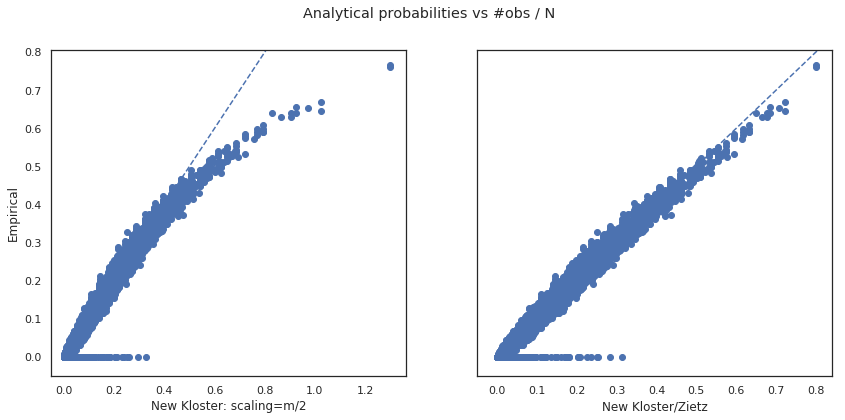

In [49]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14,6))
fig.suptitle("Analytical probabilities vs #obs / N")
axs[0].set_ylabel('Empirical')
axs[0].set_ylim([-0.05, 1.05 * max(empirical_N)])

axs[0].scatter(new_kloster, empirical_N, color='b')
axs[0].set_xlabel('New Kloster: scaling=m/2')
axs[0].set_xlim([-0.05, 1.05 * max(new_kloster)])
axs[0].plot(numpy.linspace(0, 1), numpy.linspace(0, 1), '--')

axs[1].scatter(zietz, empirical_N, color='b')
axs[1].set_xlabel('New Kloster/Zietz')
axs[1].set_xlim([-0.05, 1.05 * max(zietz)])
axs[1].plot(numpy.linspace(0, 1), numpy.linspace(0, 1), '--')

Text(0.5,0,'In degree')

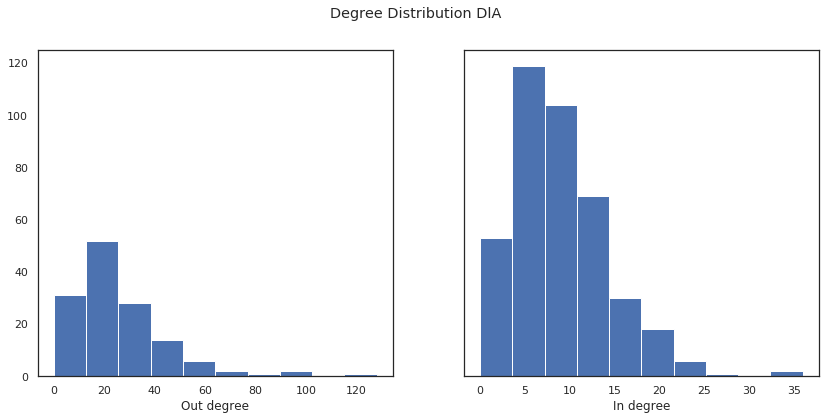

In [51]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14,6))
fig.suptitle("Degree Distribution DlA")

axs[0].hist(out_degree)
axs[0].set_xlabel("Out degree")

axs[1].hist(in_degree)
axs[1].set_xlabel("In degree")